In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import joblib

In [3]:
# Fixed seeds for reproducibility
torch.manual_seed(1)
np.random.seed(1) 

In [4]:
# Defining transformations
mnist_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalizing between -1 and 1
])

# Loading datasets
train_dataset = datasets.FashionMNIST(root="./datasets/", train=True, download=True, transform=mnist_transforms)
test_dataset = datasets.FashionMNIST(root="./datasets/", train=False, download=True, transform=mnist_transforms)

# Combining train and validation datasets
full_train_dataset = train_dataset

# Creating data loaders
train_loader = DataLoader(dataset=full_train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./datasets/FashionMNIST\raw\train-images-idx3-ubyte.gz to ./datasets/FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./datasets/FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./datasets/FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./datasets/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./datasets/FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./datasets/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./datasets/FashionMNIST\raw



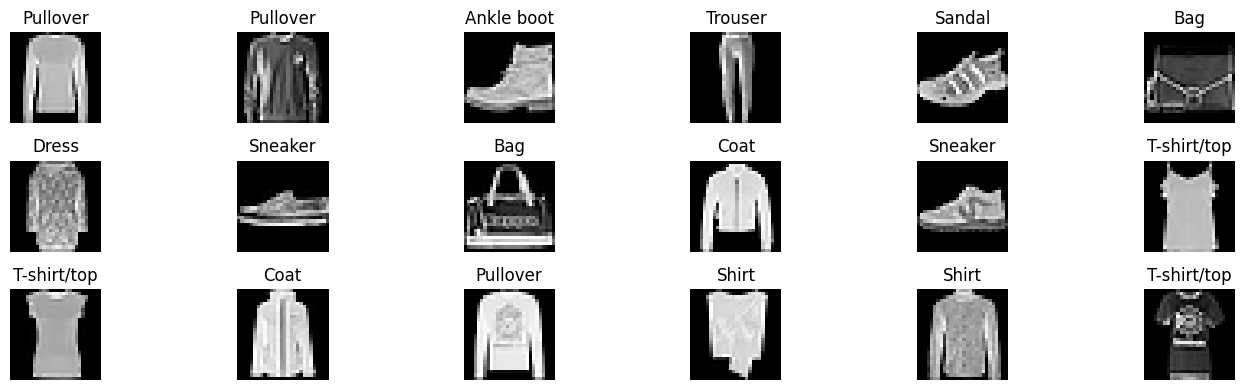

In [5]:
torch.manual_seed(1)

fig = plt.figure(figsize=(16, 4))
rows, cols = 3, 6
class_names = train_dataset.classes

# Visualizing sample images from dataset
for i in range(1, (rows * cols) + 1):
    rand_ind = torch.randint(0, len(train_dataset), size=[1]).item()
    img, label = train_dataset[rand_ind]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"{class_names[label]}")
    plt.axis('off')
    plt.tight_layout()
plt.show()

In [6]:
# Defining the variance schedule beta_t and compute alpha_bar_t

T = 500  # Total number of time steps
beta_start = 1e-4
beta_end = 0.02

# Linearly spaced beta_t from beta_start to beta_end
beta_t = torch.linspace(beta_start, beta_end, T)
# Ensuring beta_t is between 0 and 1
beta_t = torch.clamp(beta_t, 0, 0.999)

# Computing alpha_t and alpha_bar_t (cumulative product of (1 - beta_t))
alpha_t = 1 - beta_t
alpha_bar_t = torch.cumprod(alpha_t, dim=0)  # cumulative product over time

# Converting to float for numerical stability
alpha_bar_t = alpha_bar_t.float()

In [7]:
# Selecting 5 random images from the train_dataset
num_images = 5
indices = torch.randint(0, len(train_dataset), size=(num_images,))
images = []
for idx in indices:
    img, _ = train_dataset[idx]
    images.append(img)
images = torch.stack(images)  # Shape: [5, 1, 28, 28]

In [13]:
# Implementing the forward diffusion process and generate noisy images

# Defining time steps at which to visualize the corruption
time_steps = [0, 10, 50, 100, 499]  # Corresponding to t = 0, 10, 50, 100, 500

noisy_images = []  # To store the noisy images at different time steps
mse_list = []      # To store the MSE at different time steps

for t in time_steps:
    sqrt_alpha_bar_t = torch.sqrt(alpha_bar_t[t])
    sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar_t[t])
    epsilon = torch.randn_like(images)  # Sample noise from standard normal distribution
    x_t = sqrt_alpha_bar_t * images + sqrt_one_minus_alpha_bar_t * epsilon  # Forward diffusion process
    noisy_images.append(x_t)
    mse = F.mse_loss(x_t, images)  # Calculating MSE between x_t and original images x_0
    mse_list.append(mse.item())

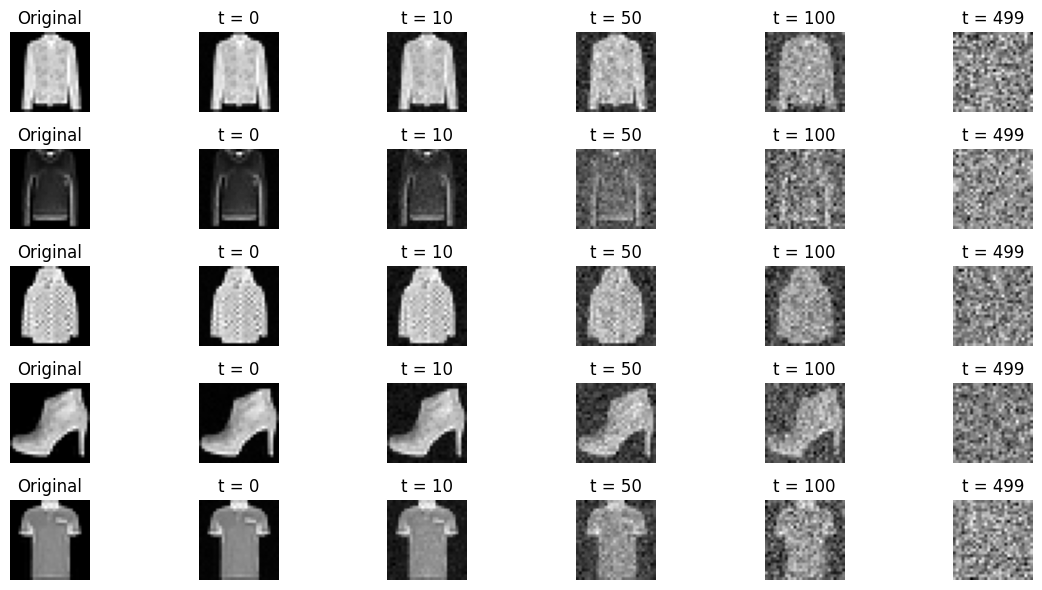

In [9]:
# Visualizing the original and progressively corrupted images

fig, axes = plt.subplots(nrows=num_images, ncols=len(time_steps)+1, figsize=(12, 6))

for i in range(num_images):
    # Plotting original image
    axes[i, 0].imshow(images[i].squeeze(), cmap='gray')
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')
    # Plotting noisy images at different time steps
    for j, x_t in enumerate(noisy_images):
        axes[i, j+1].imshow(x_t[i].squeeze(), cmap='gray')
        axes[i, j+1].set_title(f't = {time_steps[j]}')
        axes[i, j+1].axis('off')

plt.tight_layout()
plt.show()

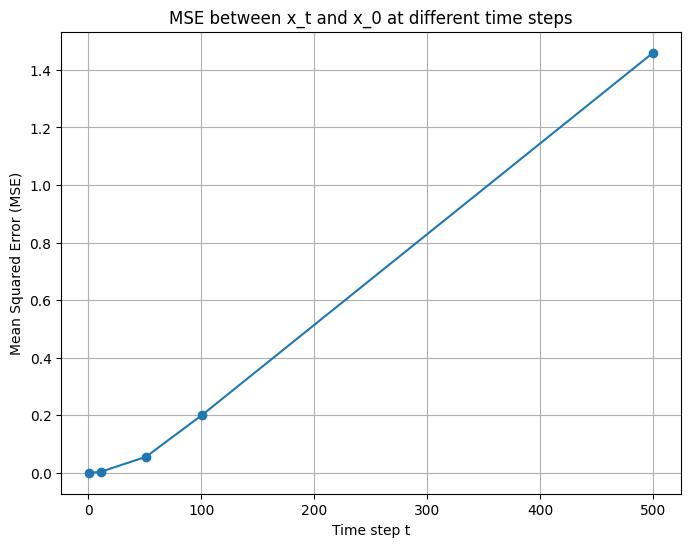

In [10]:
# Plotting the Mean Squared Error (MSE) at the selected time steps

plt.figure(figsize=(8, 6))
plt.plot([t+1 for t in time_steps], mse_list, marker='o')
plt.xlabel('Time step t')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE between x_t and x_0 at different time steps')
plt.grid(True)
plt.show()

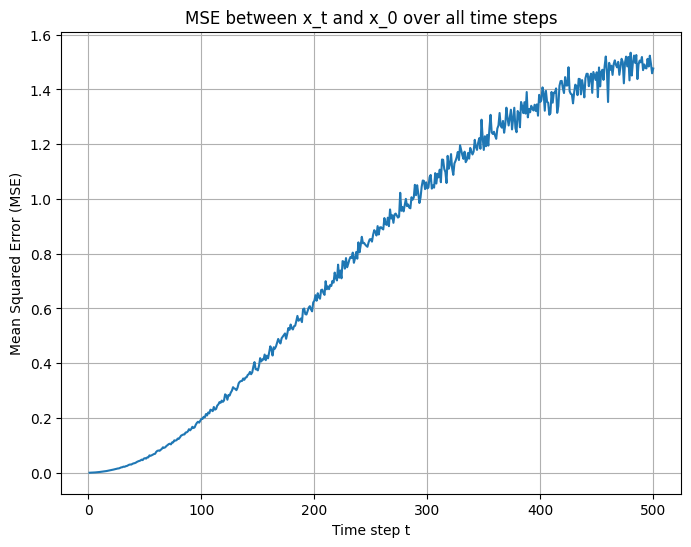

In [11]:
# (Optional) Calculating and plotting MSE over all time steps to visualize the corruption trend

all_mse = []
for t in range(T):
    sqrt_alpha_bar_t = torch.sqrt(alpha_bar_t[t])
    sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar_t[t])
    epsilon = torch.randn_like(images)
    x_t = sqrt_alpha_bar_t * images + sqrt_one_minus_alpha_bar_t * epsilon
    mse = F.mse_loss(x_t, images)
    all_mse.append(mse.item())

# Plotting MSE vs. all time steps
plt.figure(figsize=(8, 6))
plt.plot(range(1, T+1), all_mse)
plt.xlabel('Time step t')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE between x_t and x_0 over all time steps')
plt.grid(True)
plt.show()